# Technical Assessment - Kaiyun (Kiki) Kang

### The goal is to predict cognitive test scores of preschoolers given characteristics of their mothers.

In this Jupyter Notebook, I have 4 sections:
1. Load and Prepare Data
2. Transform Data
3. Exploratory Data Analysis (EDA)
4. Perform Linear Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import statsmodels.api as sm
import seaborn as sns
from statsmodels.graphics.gofplots import ProbPlot
from sklearn.preprocessing import StandardScaler
import lmdiag
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from sklearn.metrics import mean_squared_error
from math import sqrt

# 1. Load and Prepare Data
**I operate 3 tasks in Section 1:**
* Load data from file data.txt
* Rename variables for easier reading
* Change into proper python data type for each variable.

In [2]:
with open('data.txt','r',encoding='iso-8859-1') as f:
    
    all_value = [] # Store all values for 5 columns
    col_names = [] # Store all column name values in order
    
    for line in f:
        try:
            line = line.strip().split('|') # strip() deletes escape character '\n'  # split() seperates the line according to '\'
            all_value.append(eval(line[2]))
            
            if line[1] not in col_names:
                col_names.append(line[1])

        # Some lines are not in specific format and create errors, for example, '0xC0|€嗎€剙簗€涐€檧?''        
        except:
            pass
    assert len(all_value)==2170 and len(col_names)==5
    print('col_names are: ',col_names)

col_names are:  ['score', 'h', 'i', 'w', 'a']


### Data dictionary:
* i - mother's IQ
* a - mother's age at child's birth
* h - indicator showing whether mother completed high school (1=True, 0=False)
* w = 1: mother did not work in first three years of child’s life
* w = 2: mother worked in second or third year of child’s life
* w = 3: mother worked part-time in first year of child’s life
* w = 4: mother worked full-time in first year of child’s life
* score - child's IQ (regressand)

In [3]:
values = np.reshape(all_value,(5,int(len(all_value)/5))).T
df = pd.DataFrame(values,columns=col_names)
df = df[['h', 'i', 'w', 'a','score']]
df.rename(columns={'score':'Child_IQ', 'h':'Mother_HighSchool_Yes', 'i':'Mother_IQ', 'w':'Mother_Work', 'a':'Mother_Age_ChildBirth'},inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434 entries, 0 to 433
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Mother_HighSchool_Yes  434 non-null    object
 1   Mother_IQ              434 non-null    object
 2   Mother_Work            434 non-null    object
 3   Mother_Age_ChildBirth  434 non-null    object
 4   Child_IQ               434 non-null    object
dtypes: object(5)
memory usage: 17.1+ KB


### Notes:
* There are 4 predictors and 1 response. Two **categorical** features are Mother_HighSchool_Yes and Mother_Work. Three **continuous** variables are Mother_IQ, Mother_Age_ChildBirth, and Child_IQ. Here, I dealt with Age as a continuous variable.
* The shape is 434x5. There are **no missing values**.
* Since column names are recorded in order in "col_names", I can easily **rename them by their corresponding meanings**. "Mother_HighSchool_Yes"=1 means that the mother completed high school.
* I use astype to **change all objects Dtype to proper python types**. There are int and float because they are all numbers.

In [4]:
df = df.astype({'Mother_IQ':float, 'Mother_HighSchool_Yes':int, 'Mother_Age_ChildBirth':int,'Mother_Work':int,'Child_IQ':float})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434 entries, 0 to 433
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Mother_HighSchool_Yes  434 non-null    int32  
 1   Mother_IQ              434 non-null    float64
 2   Mother_Work            434 non-null    int32  
 3   Mother_Age_ChildBirth  434 non-null    int32  
 4   Child_IQ               434 non-null    float64
dtypes: float64(2), int32(3)
memory usage: 12.0 KB


In [5]:
df

,Mother_HighSchool_Yes,Mother_IQ,Mother_Work,Mother_Age_ChildBirth,Child_IQ
0,1,121.117529,4,27,65.0
1,1,89.361882,4,25,98.0
2,1,115.443165,4,27,85.0
3,1,99.449639,3,25,83.0
4,1,92.745710,4,27,115.0
...,...,...,...,...,...
429,0,84.877412,4,21,94.0
430,1,92.990392,4,23,76.0
431,0,94.859708,2,24,50.0
432,1,96.856624,2,21,88.0


# 2. Transform Data 

In this part, I transform variables by **Centering for continuous features** and **One-Hot-Encoding for categorical features** so that they are easier to analyze, modeling and be interpreted. This part **interacts with the third part EDA and fourth part Modeling**. Transformation prepares for Modeling. If facing with some assumption issues, I can also come back to part 2 to perform an appropriate transformation to solve them.


## 2.1 Centering

### Reasons:
- **Centering can make intercepts(beta0) more easier to be interpreted.** After buiding regressions, there are sometimes that the intercepts are hard to be interpreted. Because Mother_IQ=0 and Mother_Age_ChildBirth=0 are not meaningful.
- **After centering by mean, continuous features are in the similar scales and easier to process**. There are different magnitudes and meatures in our data, the model may have the bias that think large-scale feature are more important to explain the response. For example, Mother_IQ is much larger than other independent variables.  
- **Centering can be helpful in regression with interaction terms by decreasing excessive amounts of multicollinearity to some extend**.
- I choose to center data instead of standardizing data due to the consideration of easier interpretation.

In [6]:
trans_df_1 = df.copy()
trans_df_1.Mother_IQ = trans_df_1.Mother_IQ - trans_df_1.Mother_IQ.mean()
trans_df_1.Mother_Age_ChildBirth = trans_df_1.Mother_Age_ChildBirth - trans_df_1.Mother_Age_ChildBirth.mean()

In [7]:
trans_df_1

,Mother_HighSchool_Yes,Mother_IQ,Mother_Work,Mother_Age_ChildBirth,Child_IQ
0,1,21.117529,4,4.214286,65.0
1,1,-10.638118,4,2.214286,98.0
2,1,15.443165,4,4.214286,85.0
3,1,-0.550361,3,2.214286,83.0
4,1,-7.254290,4,4.214286,115.0
...,...,...,...,...,...
429,0,-15.122588,4,-1.785714,94.0
430,1,-7.009608,4,0.214286,76.0
431,0,-5.140292,2,1.214286,50.0
432,1,-3.143376,2,-1.785714,88.0


## 2.2 Encoding the Categorical Data.

### Reasons:
1. **The order does not mean much.** There is no strict order meaning on Mother_Work. For example, Mother_Work=3 (mother worked part-time in first year of child’s life) does not mean the mother works more than Mother_Work=2 (mother worked in second or third year of child’s life).

2. **Mother_Work predictor is less cardinality** of 4 so that after One-Hot Encoding there are **no dimensionality issues**.

3. **Easier to be interpreted by comparing to "reference" group.** Later, when operate linear models, I select MotherWork=1 (mother did not work in first three years) as the "reference" group and drop it in regression.

3. For dummy variable **Mother_HighSchool_Yes**, it is already assigned 1(Yes) and 0(No). 

In [8]:
trans_df = pd.get_dummies(trans_df_1, columns=['Mother_Work'])
# Rename Mother_Work categories for easier understanding
trans_df.rename(columns={'Mother_Work_1':'MotherWork_Not','Mother_Work_2':'MotherWork_2nd_3rd_Year','Mother_Work_3':'MotherWork_PT_1st_Year','Mother_Work_4':'MotherWork_FT_1st_Year'},inplace=True)
trans_df = trans_df.iloc[:, [0,1,2,4,5,6,7,3]]
trans_df

,Mother_HighSchool_Yes,Mother_IQ,Mother_Age_ChildBirth,MotherWork_Not,MotherWork_2nd_3rd_Year,MotherWork_PT_1st_Year,MotherWork_FT_1st_Year,Child_IQ
0,1,21.117529,4.214286,0,0,0,1,65.0
1,1,-10.638118,2.214286,0,0,0,1,98.0
2,1,15.443165,4.214286,0,0,0,1,85.0
3,1,-0.550361,2.214286,0,0,1,0,83.0
4,1,-7.254290,4.214286,0,0,0,1,115.0
...,...,...,...,...,...,...,...,...
429,0,-15.122588,-1.785714,0,0,0,1,94.0
430,1,-7.009608,0.214286,0,0,0,1,76.0
431,0,-5.140292,1.214286,0,1,0,0,50.0
432,1,-3.143376,-1.785714,0,1,0,0,88.0


# 3. Exploratory Data Analysis (EDA)

### I use different exploratory techniques to try to reveal properties and relationships among our sample data. Each exploratory tool has its advantages and emphasis. EDA will help build regression models and understand the question I want to solve by models. Additionally, EDA contributes to recognize some potential issues between variables before modeling.


### In summary, I utilize 8 types of plots and tables:
* **Statistical summary table** - mean, std, min, max
* **Boxplot** - medium, outliers
* **Histogram** - distribution
* **Pie chart** - proportions
* **Scatterplot matrix** - (continuous against continuous) linearity, correlation, multilinearity
* **Barplot** - (categorical against categorical) relationship
* **Pointplot** - (continuous against categorical) relationship
* **Lmplot** - (Y against X1 colored by X2) interaction term

# 3.1 Continuous Variables

### Summary Statistics Findings:
The summary statistics table gets overall information for continuous variables: <br>
- Both representing IQ points, Child_IQ std is much higher than Mother_IQ. 
- I noticed **a strange statictic value** that min of Child_IQ is 20, when min of Mother_IQ is 71.04.
- All ages are in the regular range.

In [9]:
print('Table 1: summary statistics for continuous variables')
df[['Mother_IQ', 'Mother_Age_ChildBirth', 'Child_IQ']].describe()

Table 1: summary statistics for continuous variables


,Mother_IQ,Mother_Age_ChildBirth,Child_IQ
count,434.000000,434.000000,434.000000
mean,100.000000,22.785714,86.797235
std,15.000000,2.701070,20.410688
min,71.037405,17.000000,20.000000
25%,88.660321,21.000000,74.000000
50%,97.915254,23.000000,90.000000
75%,110.272742,25.000000,102.000000
max,138.893106,29.000000,144.000000


### Box Plots Findings:
Because I noticed the Child_IQ min is strange, I write **Plot_Continuous_Box** function to **detect outliers or anomalous data points**. It is happy to see that most data fall in [Q1-1.5IQR, Q3+1.5IQR]. **However, for 'Child_IQ', their is one outlier of 20 and it is in line with my guess from table 1.** But later I try to delete the outlier and find it does not imporve the model.

In [10]:
def Plot_Continuous_Box(X_list, df):
    
    fig = plt.figure(figsize = (13,4))
    
    for i in range(1,len(X_list)+1):
        ax = fig.add_subplot(1,len(X_list),i)
        # create box plot
        sns.boxplot(data = df, y = X_list[i-3], ax=ax)
        sns.stripplot(data = df, y = X_list[i-3], color = "black", ax=ax)
    plt.tight_layout()

Fig 1: Box Plots for continuous variables


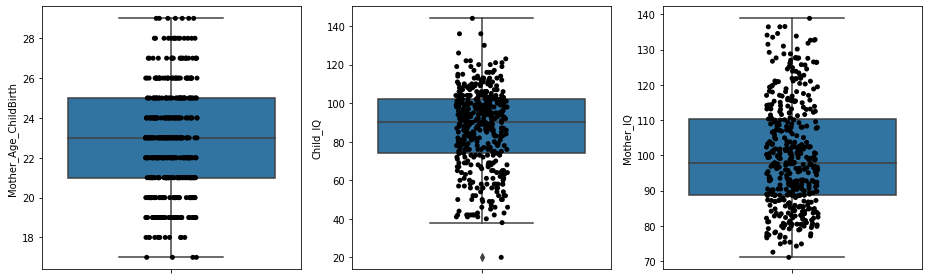

In [11]:
print('Fig 1: Box Plots for continuous variables')
Plot_Continuous_Box(['Mother_IQ', 'Mother_Age_ChildBirth', 'Child_IQ'],df)

### Distributions Findings:
Although variables are not required to be normal, it is helpful for us to explore our data. I plot **histogram** and also **Kernel Density Estimate line**.
- Mother_Age_ChildBirth is symmetric and is quite close to normal distribution.
- Mother_IQ is right_skewed which means that more mothers have higher IQ. 
- Child_IQ is left_skewed.

Fig 2: Distribution Plots for continuous variables


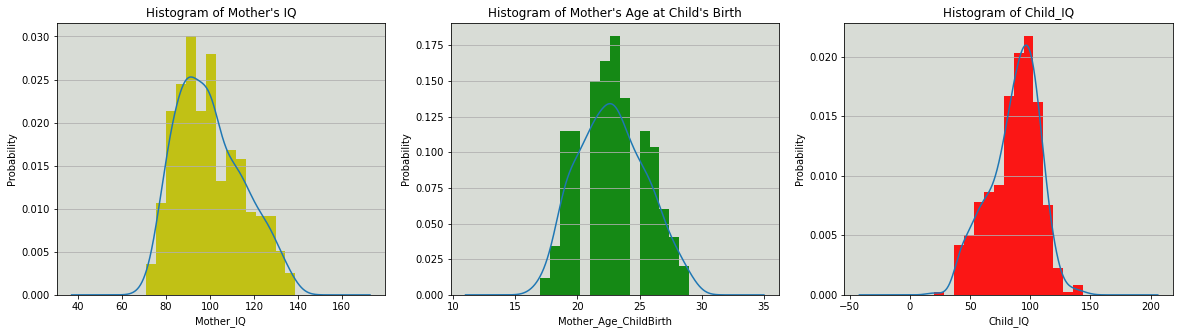

In [12]:
print('Fig 2: Distribution Plots for continuous variables')
fig, ax = plt.subplots(1,3, figsize=(20, 5))
ax[0].set_title("Histogram of Mother's IQ")
ax[1].set_title("Histogram of Mother's Age at Child's Birth")
ax[2].set_title("Histogram of Child_IQ")

for ax,column,color in zip(ax.flat,['Mother_IQ','Mother_Age_ChildBirth','Child_IQ'],['y','g','r']):
    # create histogram and kde plot
    df[column].plot.kde(ax=ax, legend=False)
    df[column].plot.hist(density=True, ax=ax, bins=15, alpha = 0.9, color=color)
    ax.set(xlabel=column,ylabel='Probability')
    ax.grid(axis='y')
    ax.set_facecolor('#d8dcd6')
plt.show()

# 3.2 Categorical Variables

### Pie chart is easy to see proportions.
   * By pie charts, we know that **most mother (78.6%) finished high school**.
   * **Mother who worked full-time in first year of child’s life** has the largest proportion (47%).
   * 18% mother did not work in first three years of child’s life 

### Box plot to see how different categories in Mother_HighSchool_Yes and Mother_Work will affect Child_IQ
* **The education level of mother may influence the child's cognitive level.** Because in figure 3, mothers finished high school has higher Child_IQ median, is more concentrated, and has higher "minimum". We can test this relationship in the later section.
* **The working status of mother has little effect on the child's cognitive level**. Because there are no much difference on medium values among different groups in Mother_Work.
* **Child_IQ of 140 and 20 are identified as outliers.**

In [13]:
def plot_categorical(X_list, Y , df):
    """
    This function is aimed to plot "CountPlot" and "BoxPlot" for categorical features
    
    X_list: a list of strings for categorical column names in dataframe
    Y: a string for target dependent nameused in Box Plot
    df: dataframe name contains data
    """
    fig = plt.figure(figsize = (15,10))
    
    for i in range(1,len(X_list)*2+1):
        ax = fig.add_subplot(2,2,i)
        if i in range(1,len(X_list)+1):
            ## create bar plot
            # g = sns.countplot(data = df, x = X_list[i-1], ax=ax)
            # g.bar_label(g.containers[0])
            #define Seaborn color palette to use
            colors = sns.color_palette('pastel')[0:5]
            #create pie chart
            plt.pie(df[X_list[i-1]].value_counts(), labels = df[X_list[i-1]].value_counts().index, colors = colors, autopct='%.0f%%')
            ax.set_title(X_list[i-1]+ ' Pie')
        
        else:
            # create box plot
            sns.boxplot(data = df, x = X_list[i-3], y = Y , ax=ax)
            sns.stripplot(data = df, x = X_list[i-3], y = Y, color = "black", ax=ax)
            ax.set_title('Boxplot of ' + Y + ' by ' + X_list[i-3])

Fig 3: Pie and Box Plots for categorical data


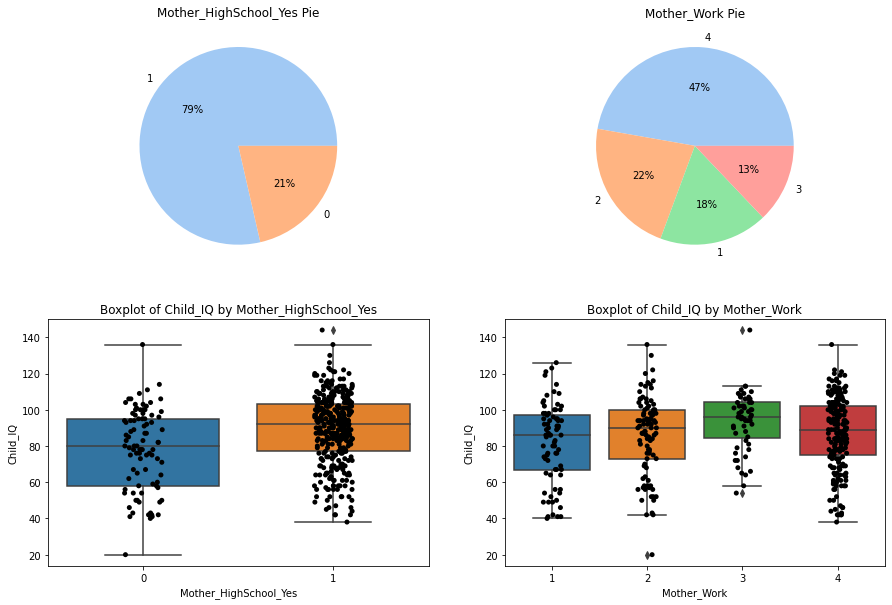

In [14]:
print('Fig 3: Pie and Box Plots for categorical data')
plot_categorical(['Mother_HighSchool_Yes','Mother_Work'], 'Child_IQ', df)

# 3.3 Plots Between Variables

## 3.3.1 Continuous against  Continuous

### Findings:
"Scatter Plot Matrix"  is great for continuous variables to see pair relationship type (linear or non-linear) and how strong the relationship is. Especially for two continuous predictors, it can detect multilinearity problems.

- **Positive linear relationship between Mother_IQ and Child_IQ** exists in scatter plot with 0.45 correlation.
- **No obvious relationship between two predictors**, which means there is **no multilinearity** between "Mother_Age_ChildBirth" and "Mother_IQ".
- **It is possible that in later model "Mother_Age_ChildBirth" will explain little about the response "Child_IQ".** Because also have little correlation in Figure 4.

Fig 4: Scatter Plot Matrix for two continuous variables


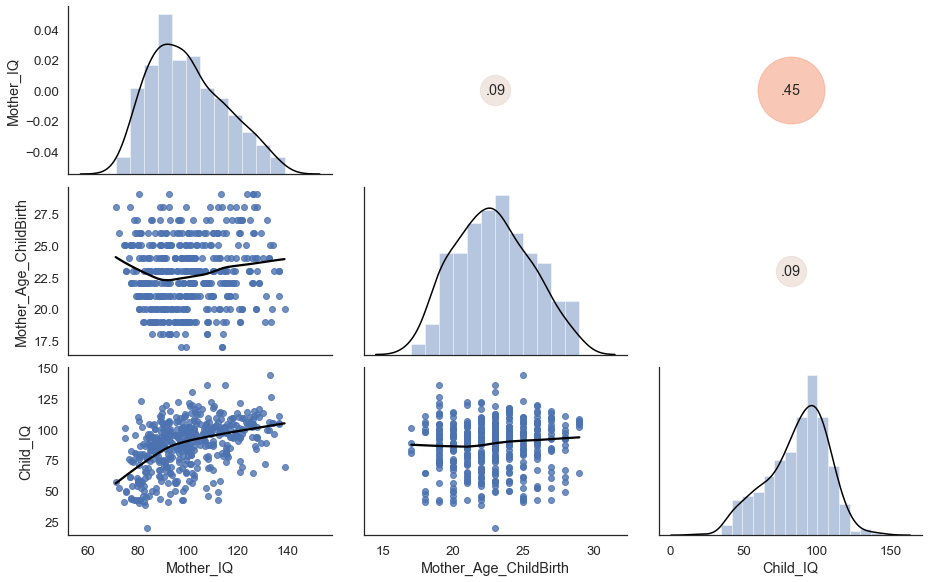

In [15]:
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",vmin=-1, vmax=1, transform=ax.transAxes)
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center')

print("Fig 4: Scatter Plot Matrix for two continuous variables")
sns.set(style='white', font_scale=1.2)
data = df[['Mother_IQ','Mother_Age_ChildBirth','Child_IQ']]

g = sns.PairGrid(data, aspect=1.4, diag_sharey=False)
g.fig.set_size_inches(13,8)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
g.map_diag(sns.distplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)

## 3.3.2 Categorical against Categorical

### Findings:
Bar plots are helpful to analyze the relationship between our two categorical predictors.
- I find **mother education level is related to mother work status**. Because in the group of Mother_HighSchool_Yes=1, the largest subgroup is mother who full-time work in the first year after child birth and the lowest is Mother_Work=1. In the group of Mother_HighSchool_Yes=0, the largest subgroup is mother who didn't work in first three years. Two categorical predictors are affected each other.

Fig 5: bar plots for Categorical against Categorical


Text(0.5, 1.0, 'Mother_HighSchool_Yes in different Mother_Work')

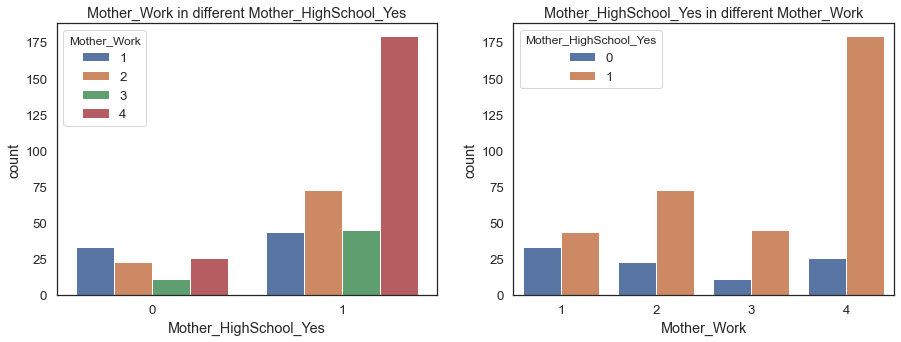

In [16]:
print("Fig 5: bar plots for Categorical against Categorical")
fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(1,2,1)
sns.countplot(x ='Mother_HighSchool_Yes', hue = "Mother_Work", data = df, ax=ax1)
ax1.set_title('Mother_Work in different Mother_HighSchool_Yes')
ax2 = fig.add_subplot(1,2,2)
sns.countplot(x = "Mother_Work", hue = 'Mother_HighSchool_Yes', data = df, ax=ax2)
ax2.set_title('Mother_HighSchool_Yes in different Mother_Work')

## 3.3.3 Continuous against Categorical

### Findings:
- **With fixed categorical variable, patterns are similar for different continuous variables.**
- **There is a difference for Child_IQ on different Mother_HighSchool_Yes values.** This is in line with Figure 4 conclusion and will be test later.
- In Fig 6, if mothers completed high school, mothers have higher IQ and tend to born baby in later ages. **But it is worrying that predictor Mother_HighSchool_Yes is related to other predictors.** This will decrease the effect of Mother_HighSchool_Yes on Child_IQ in multiple linear regression and even cause multilinearity.
- In Fig 7, looking at Y values, means of 4 types of Mother_Work's relationship fall between 10 points. This range is small for 4 types. So **there may be not significant influence from Mother_Work on Child_IQ**.

In [17]:
def plot_cat_conti_mean_std(cat, conti_list, df):
    """
    This function is aimed to plot Mean and Std for a categorical feature under a continuous feature
    
    cat: a string of a categorical column name in dataframe
    conti_list: a list of strings for continuous column names in dataframe
    df: dataframe name contains data
    """
    fig, axes = plt.subplots(len(conti_list),1, sharex=True, figsize = (4,6))
    fig.suptitle("Mean and Std for Continuous by " + cat)
    
    for i, row in enumerate(axes):
        b = sns.pointplot(data=df, x=cat, y=conti_list[i],ax=axes[i])
        b.set(xlabel=None)
        axes[i].grid(axis='y')
        
    fig.text(0.5, 0, cat, ha='center')
    plt.tight_layout()

Fig 6: Continuous Pointplot by Mother_HighSchool_Yes


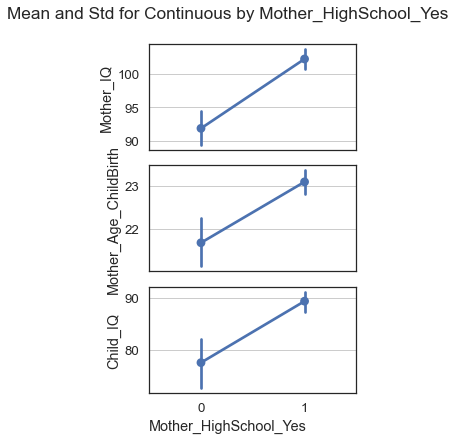

In [18]:
print('Fig 6: Continuous Pointplot by Mother_HighSchool_Yes')
plot_cat_conti_mean_std('Mother_HighSchool_Yes',['Mother_IQ','Mother_Age_ChildBirth','Child_IQ'],df)

Fig 7: Continuous Pointplot by Mother_Work


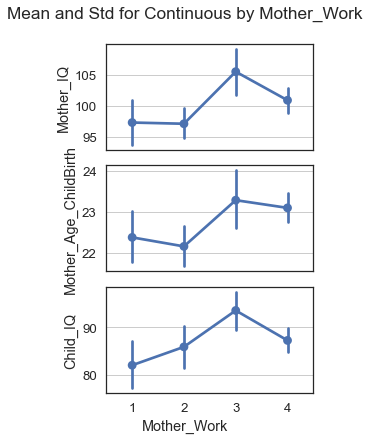

In [19]:
print('Fig 7: Continuous Pointplot by Mother_Work')
plot_cat_conti_mean_std('Mother_Work',['Mother_IQ','Mother_Age_ChildBirth','Child_IQ'],df)

## 3.3.4 Three Variables lmplot

### I use a scatterplot that plots continuous variables Y against X1. Then use different colors to represent the different levels of the categorical variable X2. This plot can detect the predictors interaction. When two predictors do not interact (parallel lines), each predictor has an "additive effect" on the response. 

### Findings:
1. **Mother_IQ and Mother_HighSchool_Yes are interacted with each other** because of no parallel lines. For a fixed mother IQ, the mean IQ of child born by high school mothers is sometimes higher and somtimes lower than the mean IQ of child born by no high school mothers.
2. **Mother_Age_ChildBirth interacts with Mother_HighSchool_Yes.**
3. We need to consider including **interaction terms** in regression model.

Fig 8: Y against X1 colored by X2


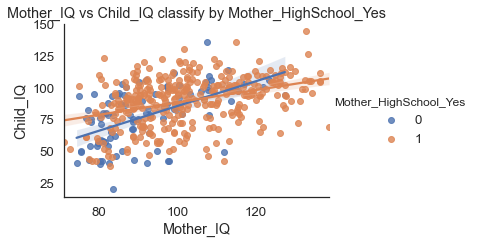

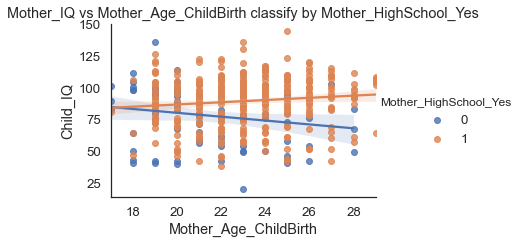

In [20]:
print('Fig 8: Y against X1 colored by X2')
g1 = sns.lmplot(x="Mother_IQ", y="Child_IQ", hue="Mother_HighSchool_Yes", data=df).set(title='Mother_IQ vs Child_IQ classify by Mother_HighSchool_Yes')
g2 = sns.lmplot(x='Mother_Age_ChildBirth', y="Child_IQ", hue="Mother_HighSchool_Yes", data=df).set(title='Mother_IQ vs Mother_Age_ChildBirth classify by Mother_HighSchool_Yes')
g1.fig.set_size_inches(7,3)
g2.fig.set_size_inches(7,3)

# 4. Perform Linear Regression

### Based on all of key findings from EDA, we can start to build models.

# 4.1 Simple Linear Regression

## 4.1.1: How mother's IQ affect child's IQ?
**I firstly choose Mother_IQ as the single predictor, because by figure 4 in EDA, we have got the positive correlation between Mother_IQ and Child_IQ**

$$Child IQ = \beta_0 + \beta_1 * Mother IQ  + \varepsilon$$

Text(0.5, 1.0, 'Child_IQ by Mother_IQ')

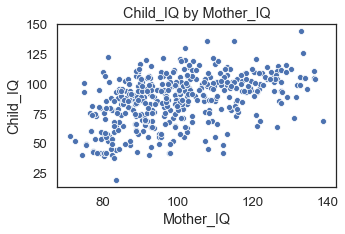

In [21]:
fig = plt.figure(figsize = (5,3))
sns.scatterplot(data=df, x="Mother_IQ", y="Child_IQ").set_title("Child_IQ by Mother_IQ")

<module 'matplotlib.pyplot' from 'D:\\Pathon\\lib\\site-packages\\matplotlib\\pyplot.py'>

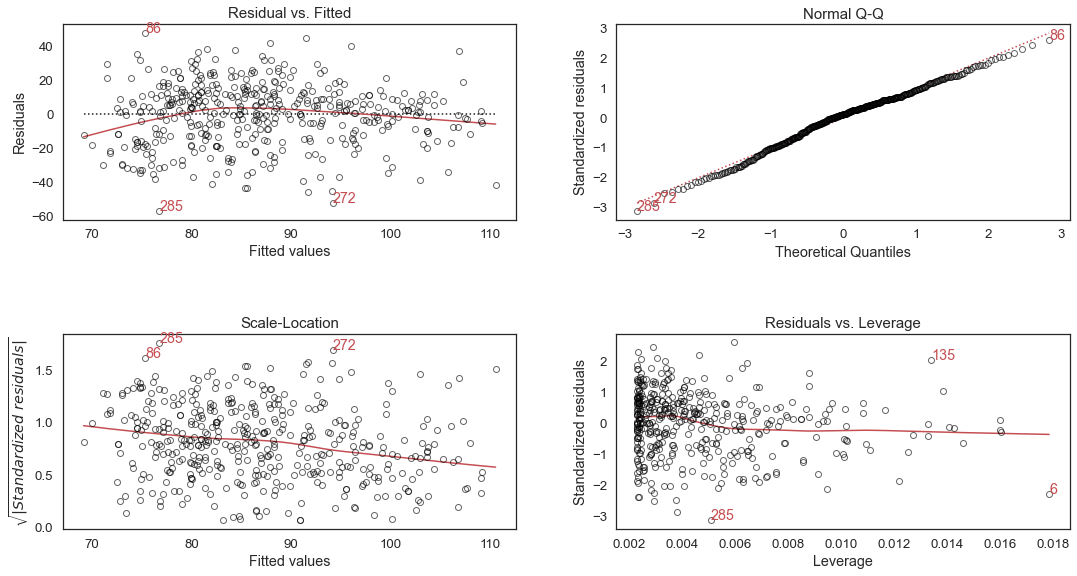

In [22]:
# Generate the model 
df_model = trans_df
Y = df_model.Child_IQ
X = df_model.Mother_IQ
lm_MotherIQ = sm.OLS(Y, sm.add_constant(X)).fit()

# Diagnostic Plot
plt.figure(figsize=(15,8))
lmdiag.plot(lm_MotherIQ)

### Assumptions are Satisfied by follwing Evidence:
- **Regression function is linear**: In "Residuals versus Fits Plot", residuals bounce randomly around 0 line. In scatterplot of Child_IQ by Mother_IQ, there is also obviously a linear trend.
- **Errors are independent**: Durbin-Watson stat is 1.645. If the Durbin-Watson stat is between 1.5 and 2.5, it is a good sign that there is no autocorrelation and errors are independent.
- **Residuals are normal**: In Normal Q-Q plot, data points follow the 45-degree line without deviating strongly.
- **Error terms have equal variance**: In "Residuals versus Fits Plot", residuals fall in "horizontal band" and there is no trend when we change fitted values from left to right. In "Scale-Location Plot", red line is roughly horizontal across the plot so that the assumption of homoscedasticity is likely satisfied.
- Additionally, in "Residual vs Leverage Plot", this model has some outliers but no influential points. Because no values are outside of the cook distance contours.

### Interpretation and Evaluation
$$Child IQ = 86.80 + 0.61 * Mother IQ  + \varepsilon$$
- $\beta_0$:  When a mother has average IQ of 100, the child's IQ is on average estimated to be 86.80 points. P-value < 0.05 indicates that it is statistically significant at a 5% level.
- $\beta_1$:  A 1 point increase in mother's IQ is associated with a increase of 0.61 points in child's IQ. P-value = 0.000 < 0.05 indicates that the variabl is statistically significant at a 5% level.
- R^2 = 0.201 means that 20.1% child IQ can be explained by mother IQ.
- Model Accuracy RMSE:  18.22

In [23]:
print(str(lm_MotherIQ.summary()))

                            OLS Regression Results                            
Dep. Variable:               Child_IQ   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     108.6
Date:                Thu, 19 Jan 2023   Prob (F-statistic):           7.66e-23
Time:                        17:54:58   Log-Likelihood:                -1875.6
No. Observations:                 434   AIC:                             3755.
Df Residuals:                     432   BIC:                             3763.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         86.7972      0.877     98.993      0.0

In [24]:
print('Model Accuracy RMSE: ', round(sqrt(mean_squared_error(trans_df.Child_IQ, lm_MotherIQ.predict())),2))

Model Accuracy RMSE:  18.22


## 4.1.2: How mother's age at child's birth affect child's IQ?
**By figure 4 in EDA, I guess that there may be weak relationship between Mother_Age_ChildBirth and Child_IQ. So I did this test to see how much mother's age at child's birth can affect child's IQ.**

$$Child IQ = \beta_0 + \beta_1 * Mother Age Child Birth  + \varepsilon$$

<module 'matplotlib.pyplot' from 'D:\\Pathon\\lib\\site-packages\\matplotlib\\pyplot.py'>

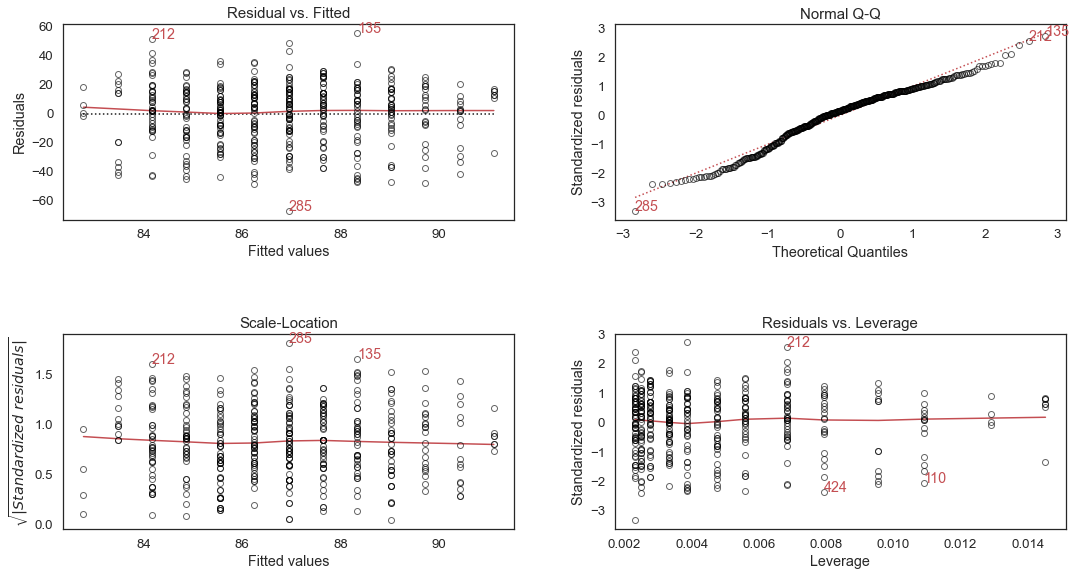

In [25]:
# Generate the model 
df_model = trans_df
Y = df_model.Child_IQ
X = df_model.Mother_Age_ChildBirth
lm_Age = sm.OLS(Y, sm.add_constant(X)).fit()

# Diagnostic Plot
plt.figure(figsize=(15,8))
lmdiag.plot(lm_Age)

### Assumptions are Satisfied:
- **Regression function is linear**: In "Residuals versus Fits Plot", the red line is horizontal and residuals bounce randomly around 0 line.
- **Errors are independent**: Durbin-Watson stat is 1.5. If the Durbin-Watson stat is between 1.5 and 2.5, it is a good sign that there is no autocorrelation and errors are independent.
- **Residuals are normal**: In Normal Q-Q plot, data points follow the 45-degree line without deviating strongly.
- **Error terms have equal variance**: In "Residuals versus Fits Plot", residuals fall in "horizontal band" and there is no trend when we change fitted values from left to right. In "Scale-Location Plot", red line is roughly horizontal across the plot so that the assumption of homoscedasticity is likely satisfied.
- Additionally, in "Residual vs Leverage Plot", this model has some outliers but no influential points. Because no values are outside of the cook distance contours.

### Interpretation and Evaluation:
$$Child IQ = 86.80 + 0.70 * Mother Age Child Birth  + \varepsilon$$
- $\beta_0$:  When a mother's age at child birth is on average level of 23, the child's IQ is on average estimated to be 86.80 points. P-value < 0.05 indicates that it is statistically significant at a 5% level.
- $\beta_1$:  A 1 year increase in mother's age at child birth is associated with a increase of 0.70 points in child's IQ. **However, P-value=0.055>0.05 indicates that the variabl is not statistically significant.** I may remove this variable in multiple linear regression at a 5% level.
- R^2 = 0.008 means that 0.8% child IQ can be explained by mother's age at child birth.
- Model Accuracy RMSE:  20.3

In [26]:
print(str(lm_Age.summary()))

                            OLS Regression Results                            
Dep. Variable:               Child_IQ   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     3.688
Date:                Thu, 19 Jan 2023   Prob (F-statistic):             0.0555
Time:                        17:54:59   Log-Likelihood:                -1922.4
No. Observations:                 434   AIC:                             3849.
Df Residuals:                     432   BIC:                             3857.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    86.79

In [27]:
print('Model Accuracy RMSE: ', round(sqrt(mean_squared_error(trans_df.Child_IQ, lm_Age.predict())),2))

Model Accuracy RMSE:  20.3


## 4.1.3: How will whether mother completed high school affect child's IQ?

**In figure 3 and 6, we have see some difference of Child's IQ mean between mother completed high school or not. Thus, I did this test to figure out if this difference is statistically significant.**

$$Child IQ = \beta_0 + \beta_1 * Mother High School Yes  + \varepsilon$$
* Mother_HighSchool_Yes = 1 if mother completed high school

In [28]:
# Generate the model 
df_model = trans_df
Y = df_model.Child_IQ
X = df_model.Mother_HighSchool_Yes
lm_HS = sm.OLS(Y, sm.add_constant(X)).fit()

In [29]:
def diagnostic_for_catgorical(model, x,df):
    fig = plt.figure(figsize=(15,4))
    ax1 = fig.add_subplot(1,3,1)
    lmdiag.q_q(model)
    ax2 = fig.add_subplot(1,3,2)
    plt.hist(model.resid, bins=10) 
    plt.ylabel('Frequency')
    plt.xlabel('Residual Value')
    plt.title('Histogram of the Residuas')
    ax3 = fig.add_subplot(1,3,3)
    df_temp = pd.DataFrame({x:df[x].values,'Residual':model.resid})
    sns.boxplot(data = df_temp, x = x, y = 'Residual')
    plt.tight_layout()

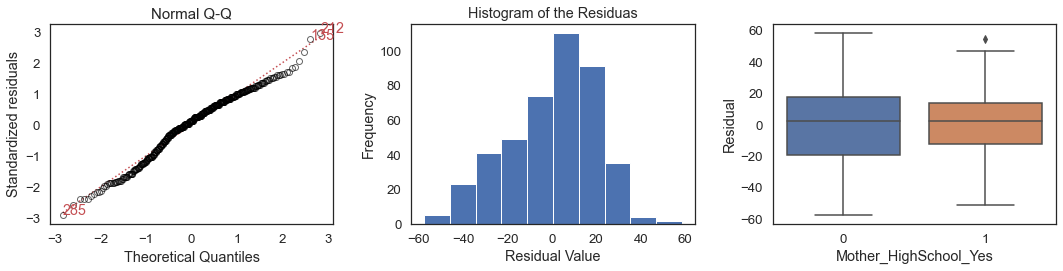

In [30]:
# Diagnostic Plot
diagnostic_for_catgorical(lm_HS, "Mother_HighSchool_Yes",df_model)

### Assumptions Analysis:
- **Regression function is linear**: In the residual box plot, there are no obvious trends and the lines are around 0 line.
- **Errors are independent**: Durbin-Watson stat is 1.5. If the Durbin-Watson stat is between 1.5 and 2.5, it is a good sign that there is no autocorrelation and errors are independent.
- **Residuals are normal**: In Normal Q-Q plot, data points generally follow the 45-degree line without deviating strongly.
- **Error terms different variance**: In the residual box plot, variances are differen.

### Interpretation and Evaluation:
$$Child IQ = 77.55 + 11.77 * Mother High School Yes  + \varepsilon$$
- $\beta_0$:  If a mother did not complete high school, her child's IQ is on average estimated to be 77.55 points. P-value < 0.05 indicates that it is statistically significant at a 5% level.
- $\beta_1$:  IQ of child born by mother completed high school is on average 11.77 points higher than IQ of child born by mother not completed high school. P-value = 0.000 < 0.05 indicates that the variabl is statistically significant at a 5% level.
- R^2 = 0.056 means that 5.6% child IQ can be explained if mother completed high school.
- Model Accuracy RMSE:  19.81

In [31]:
print(str(lm_HS.summary()))

                            OLS Regression Results                            
Dep. Variable:               Child_IQ   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     25.69
Date:                Thu, 19 Jan 2023   Prob (F-statistic):           5.96e-07
Time:                        17:55:00   Log-Likelihood:                -1911.8
No. Observations:                 434   AIC:                             3828.
Df Residuals:                     432   BIC:                             3836.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    77.54

In [32]:
print('Model Accuracy RMSE: ', round(sqrt(mean_squared_error(trans_df.Child_IQ, lm_HS.predict())),2))

Model Accuracy RMSE:  19.81


# 4.2 using multiple predictors （Multiple Linear Regression）

## 4.2.1 Using ALL 6 Predictors

In [33]:
# fit multiple linear regression model
multi_lm = ols('Child_IQ ~ Mother_IQ + Mother_HighSchool_Yes + MotherWork_2nd_3rd_Year + MotherWork_PT_1st_Year + MotherWork_FT_1st_Year + Mother_Age_ChildBirth',
                   data=trans_df).fit()

### Diagnostic Plots and Tests

<module 'matplotlib.pyplot' from 'D:\\Pathon\\lib\\site-packages\\matplotlib\\pyplot.py'>

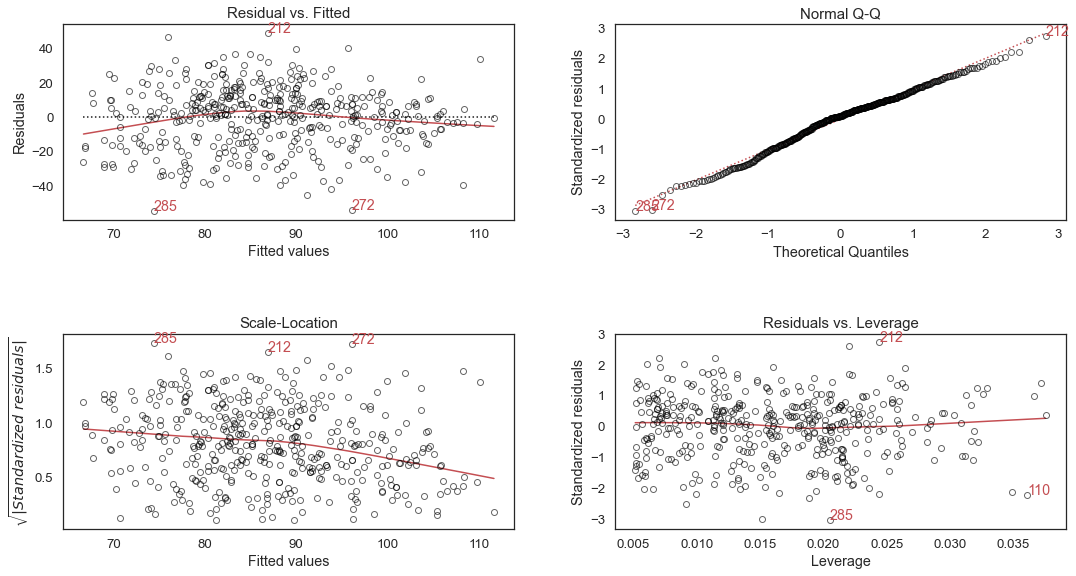

In [34]:
# Diagnostic Plot
plt.figure(figsize=(15,8))
lmdiag.plot(multi_lm)

**Calculating VIF for each feature**

In [35]:
def VIF(X_list,df):
    features = df[X_list]
    
    vif_df = pd.DataFrame()
    vif_df["Features"] = features.columns
    vif_df["VIF Factor"] = [variance_inflation_factor(features.values, i) for i in range(len(features.columns))]
    
    print(vif_df.sort_values("VIF Factor").round(2))

VIF(['Mother_HighSchool_Yes', 'Mother_IQ', 'Mother_Age_ChildBirth', 'MotherWork_2nd_3rd_Year', 'MotherWork_PT_1st_Year','MotherWork_FT_1st_Year'],trans_df)

NameError: name 'variance_inflation_factor' is not defined

**Homoscedasticity (Breush-Pagan Lagrange Multiplier test)**

In [ ]:
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(multi_lm.resid, multi_lm.model.exog)
lzip(name, test)

### Check Assumptions: 

- **Regression function is linear**:  In "Residuals versus Fits Plot", residuals bounce randomly around 0 line and there is no special trend.
- **Errors are independent**: Durbin-Watson stat is 1.612. If the Durbin-Watson stat is between 1.5 and 2.5, it is a good sign that there is no autocorrelation and errors are independent.

- **Homoscedasticity**: By Breush-Pagan Lagrange Multiplier test, p-value is 0.08 above 0.05, which means we can accept the null hypothesis. Therefore, we have an indication of homoscedasticity. In "Residuals versus Fits Plot", residuals fall in "horizontal band" and there is no trend when we change fitted values from left to right.

- **Multivariate normality**: In Normal Q-Q plot, data points follow the 45-degree line without deviating strongly.

- No Multicollinearity: As a rule of thumb, all VIF (Variance Inflation Factor) values are less than 5 and indicate no multicollinearity.

- Additionally, in "Residual vs Leverage Plot", this model has some outliers but no influential points. Because no values are outside of the cook distance contours.

In [ ]:
# display model summary
print(multi_lm.summary())

In [ ]:
print('Model Accuracy RMSE: ', round(sqrt(mean_squared_error(trans_df.Child_IQ, multi_lm.predict())),2))

### Interpreation and Evaluation:
- **P-values** for ["MotherWork_2nd_3rd_Year", "MotherWork_PT_1st_Year","MotherWork_FT_1st_Year","Mother_Age_ChildBirth"] are [0.29,0.09,0.57,0.52] and are all above 0.05. Thus, these four predictors are not statistically significant at 5% level.
- **Intercept**: If a mother has average IQ of 100, did not complete high school, born baby at average age of 23, and did not work in first three years, her child's IQ is on average estimated to be 80.49 points. P-value < 0.05 indicates that it is statistically significant.
- **Mother_IQ coefficient**:  Holding all other features constant, a 1 point increase in mother's IQ is associated with a increase of 0.55 points in child's IQ. P-value = 0.000 < 0.05 indicates that the variabl is statistically significant.
- **Mother_HighSchool_Yes coefficient**:  Holding all other features constant, IQ of a child born by mother completed high school is on average 5.43 points higher than IQ of child born by mother not completed high school. P-value = 0.02 < 0.05 indicates that the variabl is statistically significant.
- R-squared is 22.1%
- Model Accuracy RMSE:  17.99

## 4.2.2 Using Mother_IQ and Mother_HighSchool_Yes as Predictors
**By removing all insignificant predictors from the model, I got the following model:**

$$Child IQ = \beta_0  +  \beta_1 * Mother IQ  +  \beta_2*Mother High School Yes + \varepsilon$$

In [ ]:
# fit multiple linear regression model
final_multi_lm = ols('Child_IQ ~ Mother_IQ + Mother_HighSchool_Yes ', data=trans_df).fit()

### Diagnostic Plots and Tests

In [ ]:
# Diagnostic Plot
plt.figure(figsize=(15,8))
lmdiag.plot(final_multi_lm)

**Calculating VIF for each feature**

In [ ]:
VIF(['Mother_IQ', 'Mother_HighSchool_Yes'],trans_df)

**Heteroskedasticity (Breush-Pagan Lagrange Multiplier test)**

In [ ]:
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(final_multi_lm.resid, final_multi_lm.model.exog)
lzip(name, test)

### Check Assumptions: 

- **Regression function is linear**:  In "Residuals versus Fits Plot", residuals bounce randomly around 0 line and there is no special trend.
- **Errors are independent**: Durbin-Watson stat is 1.625. If the Durbin-Watson stat is between 1.5 and 2.5, it is a good sign that there is no autocorrelation and errors are independent.

- **Homoscedasticity**: By Breush-Pagan Lagrange Multiplier test, p-value is above 0.05, which means we can accept the null hypothesis. Therefore, we have an indication of homoscedasticity. In "Residuals versus Fits Plot", residuals fall in "horizontal band" and there is no trend when we change fitted values from left to right.

- **Multivariate normality**: In Normal Q-Q plot, data points follow the 45-degree line without deviating strongly.

- **No Multicollinearity**: As a rule of thumb, all VIF (Variance Inflation Factor) values are less than 5 and indicate no multicollinearity.

- Additionally, in "Residual vs Leverage Plot", this model has some outliers but no influential points. Because no values are outside of the cook distance contours.

### Interpreation and Evaluation:
$$Child IQ = 82.12 + 0.56 * Mother IQ + 5.95*Mother High School Yes + \varepsilon$$

- $\beta_0$: If a mother has average IQ of 100 and did not complete high school, her child's IQ is on average estimated to be 82.12 points. P-value < 0.05 indicates that it is statistically significant.
- $\beta_1$:  With the same value of if mother completed high school, a 1 point increase in mother's IQ is associated with a increase of 0.56 points in child's IQ. P-value = 0.000 < 0.05 indicates that the variabl is statistically significant.
- $\beta_2$:  Holding mother's IQ same, IQ of child born by mother completed high school is on average 5.95 points higher than IQ of child born by mother not completed high school. P-value = 0.007 < 0.05 indicates that the variabl is statistically significant.
- R^2 = 0.214 means that 21.4% child IQ can be explained by mother IQ.
- Model Accuracy RMSE:  18.07

In [ ]:
# display model summary
print(final_multi_lm.summary())

In [ ]:
print('Model Accuracy RMSE: ', round(sqrt(mean_squared_error(trans_df.Child_IQ, final_multi_lm.predict())),2))

# 4.3 Using Multiple Predictors with an Interaction Term

**I choose "Mother_IQ*Mother_HighSchool_Yes" as the interaction term because in Figure 8 of EDA, the Lmplot shows that Mother_IQ and Mother_HighSchool_Yes are interacted with each other.**

$$Child IQ = \beta_0  +  \beta_1 * Mother IQ  +  \beta_2*Mother High School Yes + \beta_3*(Mother IQ*Mother High School Yes) + \varepsilon$$

In [ ]:
# fit multiple linear regression model
trans_df['HS_Mother_IQ'] = trans_df['Mother_HighSchool_Yes'] * trans_df['Mother_IQ']
multi_lm_interact = ols('Child_IQ ~ Mother_IQ + Mother_HighSchool_Yes + HS_Mother_IQ',data=trans_df).fit()

### Diagnostic Plots and Tests

In [ ]:
# Diagnostic Plot
plt.figure(figsize=(15,8))
lmdiag.plot(multi_lm_interact)

**Calculating VIF for each feature (The VIT value is decreased by centering data into small scale.)**

In [ ]:
# Before centering
df['HS_Mother_IQ'] = df['Mother_HighSchool_Yes'] * df['Mother_IQ']
VIF(['Mother_IQ', 'Mother_HighSchool_Yes', 'HS_Mother_IQ'],df)

In [ ]:
# Now
VIF(['Mother_IQ', 'Mother_HighSchool_Yes', 'HS_Mother_IQ'],trans_df)

**Heteroskedasticity (Breush-Pagan Lagrange Multiplier test)**

In [ ]:
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(multi_lm_interact.resid, multi_lm_interact.model.exog)
lzip(name, test)

### Check Assumptions: 

- **Regression function is linear**:  In "Residuals versus Fits Plot", residuals bounce randomly around 0 line and there is no special trend. The red line is closer to 0 line compared to previous models.
- **Errors are independent**: Durbin-Watson stat is 1.66. If the Durbin-Watson stat is between 1.5 and 2.5, it is a good sign that there is no autocorrelation and errors are independent.
- **Homoscedasticity**: By Breush-Pagan Lagrange Multiplier test, p-value is 0.17 and above 0.05, which means we can accept the null hypothesis. Therefore, we have an indication of homoscedasticity. In "Residuals versus Fits Plot", residuals fall in "horizontal band" and there is no trend when we change fitted values from left to right.

- **Multivariate normality**: In Normal Q-Q plot, data points follow the 45-degree line without deviating strongly.

- **No Multicollinearity**: As a rule of thumb, all VIF values are less than 5 and indicate the presence of multicolinearity. The VIT value is decreased by centering data.

- Additionally, in "Residual vs Leverage Plot", this model has some outliers but no influential points. Because no values are outside of the cook distance contours.

In [ ]:
# display model summary
print(multi_lm_interact.summary())

In [ ]:
print('Model Accuracy RMSE: ', round(sqrt(mean_squared_error(trans_df.Child_IQ, multi_lm_interact.predict())),2))

### Interpreation and Evaluation:
Before Centering:
$$Child IQ = -11.48 + 0.97 * Mother IQ + 51.27*Mother High School Yes - 0.48*HSMotherIQ + \varepsilon$$
After Centering:
$$Child IQ = 85.41 + 0.97 * Mother IQ + 2.84*Mother High School Yes - 0.48*HSMotherIQ + \varepsilon$$

**Obviously, the intercept is meaningful after centering. Before centering, -11.48 Child_IQ and 0 Mother_IQ are meaningless.**

- $\beta_0$: If a mother has average IQ of 100 and did not complete high school, her child's IQ is on average estimated to be 85.41 points. P-value = 0.40 > 0.05 indicates that it is not statistically significant.
- $\beta_1$:  If a mother didn't complete high school, a 1 point increase in the mother's IQ is associated with a increase of 0.97 points in child's IQ. P-value = 0.000 < 0.05 indicates that the variabl is statistically significant.
- $\beta_2$:  If a mother is with average IQ of 100, IQ of child born by the mother completed high school is on average 2.84 points higher than IQ of child born by the mother not completed high school. P-value = 0.242 > 0.05 indicates that the variabl is not statistically significant.
- $\beta_3$:  The difference in slope for mother's IQ between those mothers who did and did not complete high school is 0.48

- R^2 = 0.23 means that 23% child IQ can be explained by mother IQ. R^2 is improved by this model.
- Model Accuracy RMSE:  17.89. It is the lowest RMSE among all models I have tried.

### Thanks for your time!